In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

**CV2 Segmentation**

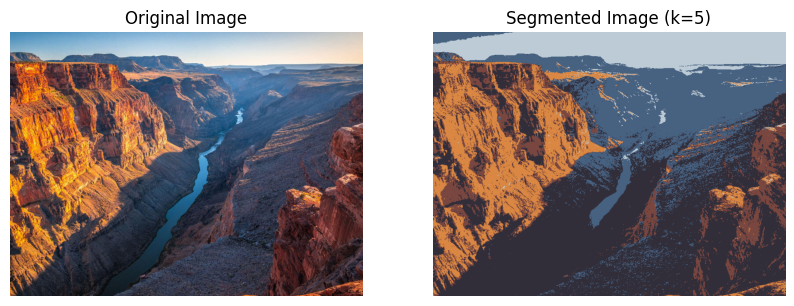

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Kmeans_segmentation/image1.png')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pixel_vals = image.reshape((-1,3))

pixel_vals = np.float32(pixel_vals)

#the criteria for the algorithm to stop running,
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

k = 5
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

segmented_image = segmented_data.reshape((image.shape))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmented Image (k={})".format(k))
plt.imshow(segmented_image)
plt.axis("off")

plt.show()

**kmeans image segmentation from scratch**

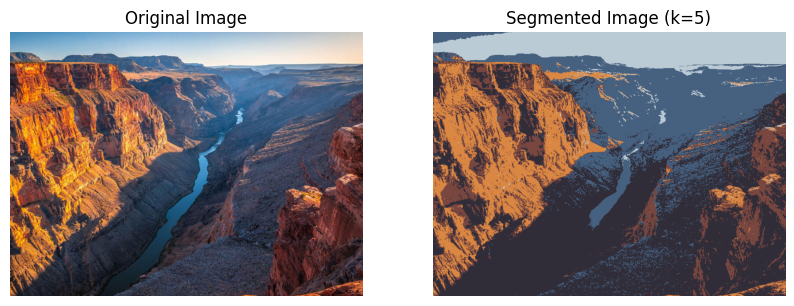

In [ ]:
from matplotlib.image import imread

def kmeans_segmentation(image, k, max_iters=10):
    original_shape = image.shape
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    pixels = image.reshape(-1, 3).astype(float)

    np.random.seed(42)  #
    centroids = pixels[np.random.choice(pixels.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # distances to centroids
        distances = np.linalg.norm(pixels[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(distances, axis=1)  # assign each pixel to the nearest centroid

        new_centroids = np.array([pixels[labels == i].mean(axis=0) for i in range(k)])
        # if empty clusters
        for i in range(k):
            if np.isnan(new_centroids[i]).any():
                new_centroids[i] = pixels[np.random.choice(pixels.shape[0])]

        # check for convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    segmented_pixels = centroids[labels].astype(np.uint8)
    segmented_image = segmented_pixels.reshape(original_shape)

    return segmented_image

image = imread("/content/drive/MyDrive/Colab Notebooks/Kmeans_segmentation/image1.png")
if image.dtype == np.float32 or image.dtype == np.float64:
    image = (image * 255).astype(np.uint8)

k = 5
segmented_image = kmeans_segmentation(image, k)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Segmented Image (k={k})")
plt.imshow(segmented_image)
plt.axis("off")

plt.show()


**MEAN SHIFT implementation**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import MeanShift, estimate_bandwidth
from google.colab.patches import cv2_imshow

Original Image:


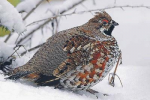

Segmented Image:


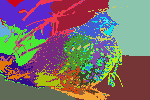

In [7]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Kmeans_segmentation/image5.png'
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Unable to load image at {image_path}")
else:

    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    flat_image = lab_image.reshape((-1, 3))

    height, width, _ = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    flat_image_with_coordinates = np.column_stack([flat_image, x.flatten(), y.flatten()])

    bandwidth = 20

    mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    mean_shift.fit(flat_image_with_coordinates)
    labels = mean_shift.labels_

    segmented_image = labels.reshape((height, width))

    unique_labels = np.unique(labels)
    segmented_colors = np.random.randint(0, 255, size=(len(unique_labels), 3))
    colored_segmented_image = segmented_colors[segmented_image]

    print("Original Image:")
    cv2_imshow(image)

    print("Segmented Image:")
    cv2_imshow(colored_segmented_image.astype(np.uint8))


**DBSCAN implementation**

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

Количество кластеров: 52


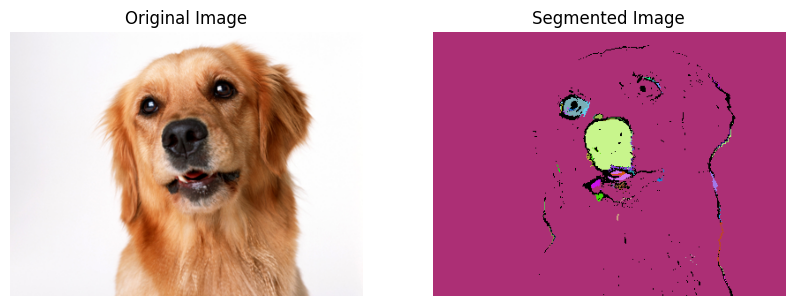

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Kmeans_segmentation/image7.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


height, width, channels = image.shape


X = []
for y in range(height):
    for x in range(width):
        r, g, b = image[y, x]
        X.append([x, y, r, g, b])

X = np.array(X)


eps = 10  # hадиус для поиска соседей
min_samples = 10  # минимальное количество точек для формирования кластера


dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
labels = dbscan.fit_predict(X)


num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {num_clusters}")


segmented_image = np.zeros((height, width, 3), dtype=np.uint8)

for y in range(height):
    for x in range(width):
        label = labels[y * width + x]
        if label == -1:
            color = [0, 0, 0]
        else:
            np.random.seed(label)
            color = np.random.randint(0, 255, size=3)
        segmented_image[y, x] = color

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Segmented Image")
plt.imshow(segmented_image)
plt.axis("off")

plt.show()



**Adaptive threshold implementation**

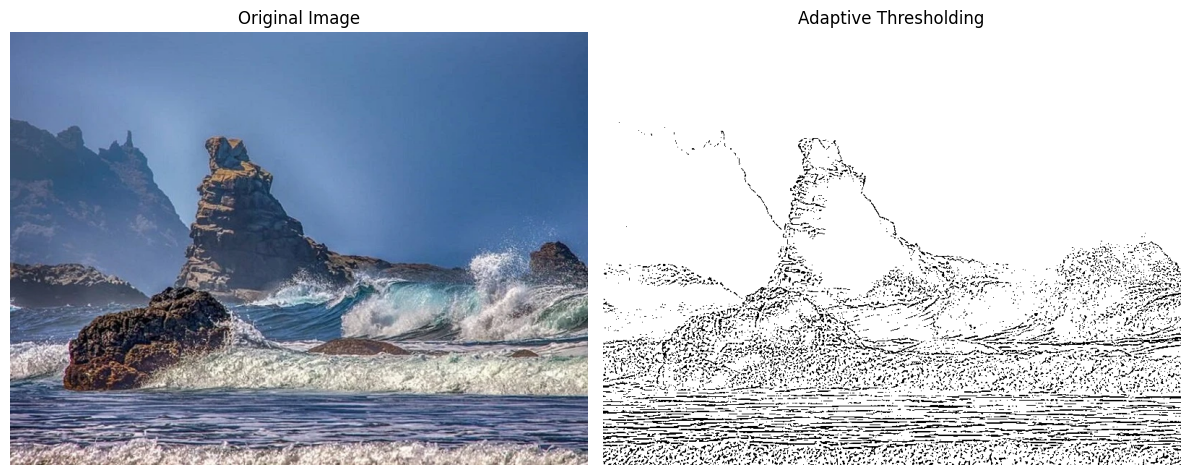

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Kmeans_segmentation/image2.png")
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

adaptive_thresh = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,   # Метод пороговой обработки
    cv2.THRESH_BINARY,                 # Тип порога
    blockSize=11,                      # Размер блока (должен быть нечетным)
    C=20                                # Константа для регулировки порога
)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adaptive_thresh, cmap='gray')
plt.title('Adaptive Thresholding')
plt.axis('off')

plt.tight_layout()
plt.show()


In [2]:
from skimage.data import astronaut
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.util import img_as_float

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:750: RuntimeWarning: invalid value encountered in cast
  lut = (lut * 255).astype(np.uint8)


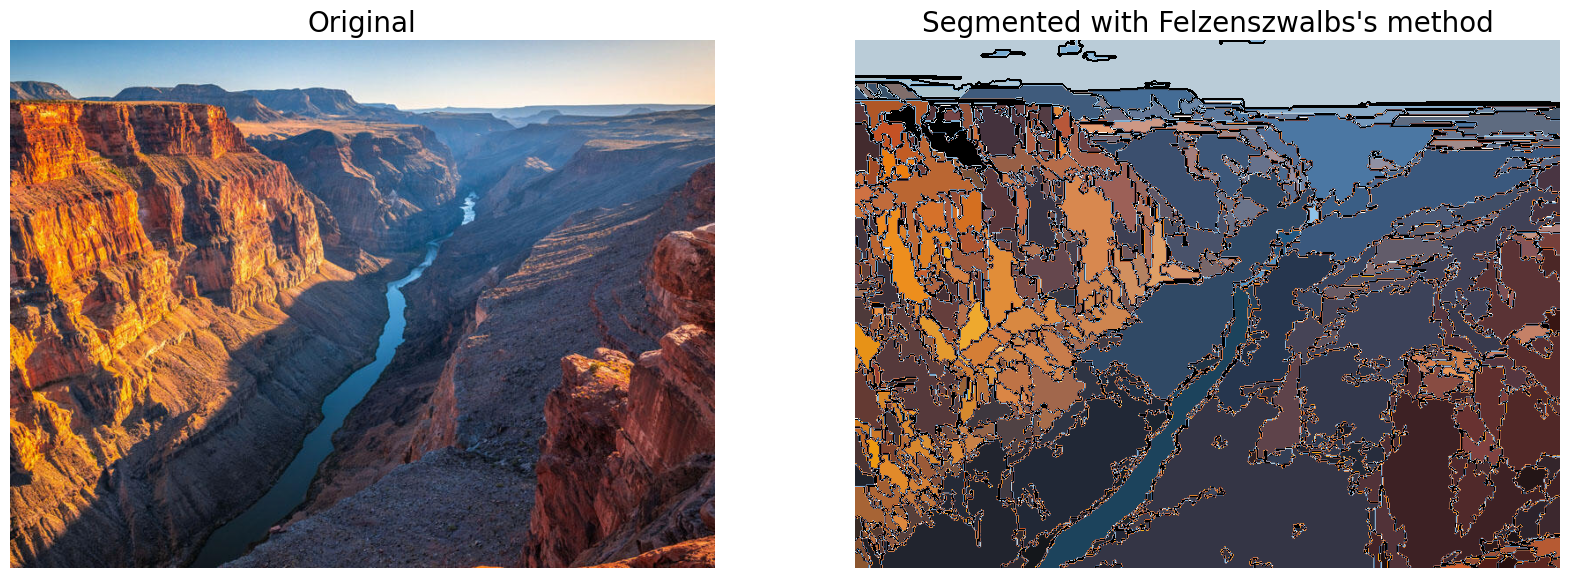

In [5]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

img = img_as_float(imread("/content/drive/MyDrive/Colab Notebooks/Kmeans_segmentation/image1.png"))
plt.figure(figsize=(20,10))

segments_fz = felzenszwalb(img, scale=100, sigma=1, min_size=100) #300
borders = find_boundaries(segments_fz)
unique_colors = np.unique(segments_fz.ravel())
segments_fz[borders] = -1 #len(unique_colors)
colors = [np.zeros(3)]

for color in unique_colors:
    colors.append(np.mean(img[segments_fz == color], axis=0))

cm = LinearSegmentedColormap.from_list('pallete', colors, N=len(colors))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original', size=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segments_fz, cmap=cm)
plt.title('Segmented with Felzenszwalbs\'s method', size=20)
plt.axis('off')

plt.show()